In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import random
import cv2
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization ,Activation, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##data splitting

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

# Path ke dataset utama
dataset_path = "/content/drive/My Drive/TA/dataset_gabungan_equalized/lanjutkan"

# List semua gambar dan labelnya
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            all_images.append(os.path.join(class_path, img_name))
            all_labels.append(class_name)

# Split dataset (70% train, 20% valid, 10% test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels)
valid_imgs, test_imgs, valid_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=1/3, stratify=temp_labels)

# Fungsi untuk memindahkan file ke folder baru
def move_files(image_list, labels, destination_folder):
    for img_path, label in zip(image_list, labels):
        dest_folder = os.path.join(destination_folder, label)
        os.makedirs(dest_folder, exist_ok=True)
        shutil.copy(img_path, dest_folder)

# Tentukan folder tujuan
train_dir = "/content/drive/My Drive/TA/dataset_split/train"
valid_dir = "/content/drive/My Drive/TA/dataset_split/valid"
test_dir = "/content/drive/My Drive/TA/dataset_split/test"

# Pindahkan file sesuai split
move_files(train_imgs, train_labels, train_dir)
move_files(valid_imgs, valid_labels, valid_dir)
move_files(test_imgs, test_labels, test_dir)

print("Dataset berhasil dipisah ke folder train, valid, dan test.")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/My Drive/TA/dataset_split/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/drive/My Drive/TA/dataset_split/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/My Drive/TA/dataset_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2042 images belonging to 5 classes.
Found 581 images belonging to 5 classes.
Found 292 images belonging to 5 classes.


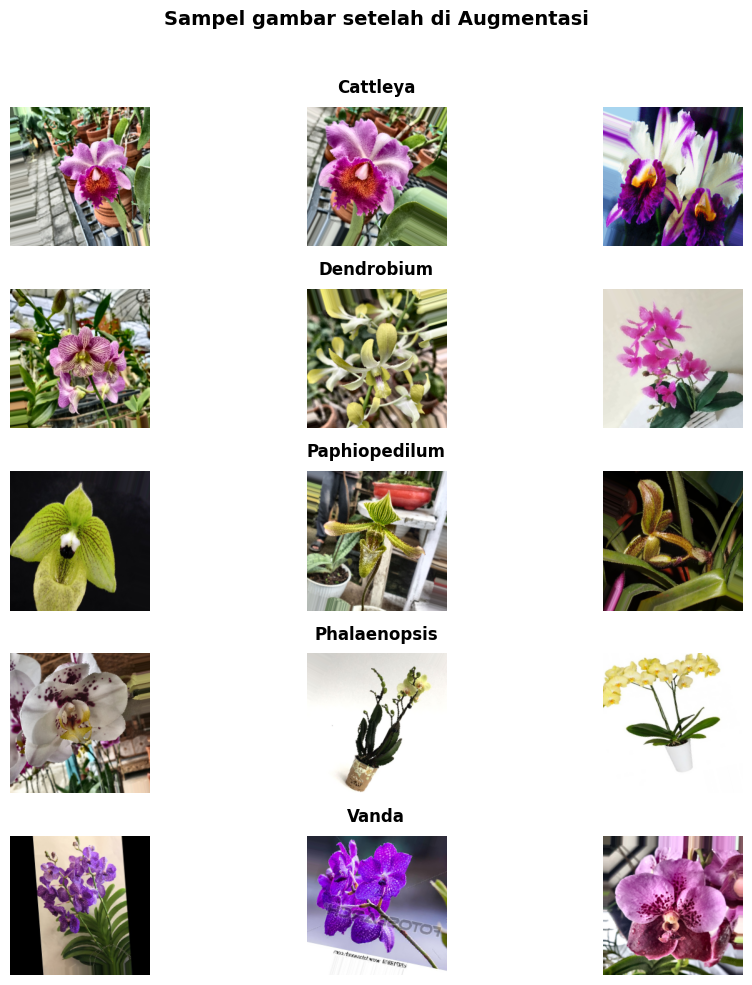

In [ ]:
# Ambil satu batch dari train_generator
sample_batch, labels = next(train_generator)

# Mendapatkan daftar nama kelas dari train_generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # Nama kelas sesuai urutan label

# Tentukan jumlah kelas (genus) dan jumlah sample per genus
num_classes = len(class_names)
samples_per_class = 3  # Menampilkan 3 sample per genus

# Buat figure untuk menampilkan gambar per genus
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, num_classes * 2))
fig.suptitle("Sampel gambar setelah di Augmentasi", fontsize=14, fontweight="bold")

# Loop untuk setiap kelas/genus
for i in range(num_classes):
    # Cari indeks gambar yang termasuk dalam kelas/genus tersebut
    class_idx = np.argmax(labels, axis=1)  # Ambil indeks kelas dari one-hot encoding
    sample_idx = np.where(class_idx == i)[0]  # Cari indeks gambar dengan kelas yang sama

    # Tambahkan judul di tengah atas per genus
    mid_col = samples_per_class // 2  # Kolom tengah untuk posisi judul
    axes[i, mid_col].set_title(class_names[i], fontsize=12, fontweight="bold", pad=10)

    for j in range(samples_per_class):  # Ambil 3 gambar per genus
        if j < len(sample_idx):  # Pastikan cukup sample tersedia
            axes[i, j].imshow(sample_batch[sample_idx[j]])  # Tampilkan gambar
        axes[i, j].axis("off")  # Hilangkan sumbu

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Sesuaikan tata letak agar judul utama terlihat
plt.show()


In [ ]:
print(train_generator.class_indices)  # Mengecek mapping label ke indeks
print(train_generator.samples)        # Mengecek jumlah sample di training set
print(valid_generator.samples)        # Mengecek jumlah sample di validation set
print(test_generator.samples)         # Mengecek jumlah sample di test set

{'Cattleya': 0, 'Dendrobium': 1, 'Paphiopedilum': 2, 'Phalaenopsis': 3, 'Vanda': 4}
2042
581
292


In [ ]:
# 4. Load Pre-trained VGG19
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-4:]:  # Buka 4 layer terakhir
    layer.trainable = True

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Lebih ringan!
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(5, activation="softmax")
])

In [ ]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import TopKCategoricalAccuracy

model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5, beta_2=0.99),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=2, name="top_2_acc")]
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_delta=1e-4, min_lr=1e-6, verbose=1),  # Lebih stabil
    EarlyStopping(monitor='val_loss', patience=6, min_delta=1e-4, restore_best_weights=True, verbose=1),  # Cegah overfitting lebih cepat
    ModelCheckpoint("best_model.keras", monitor="val_loss",  mode="min", save_best_only=True, save_weights_only=False, verbose=1)  # Simpan model terbaik
]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // 2,  # Hemat waktu training
    epochs=30,  # Mulai dari 20 epoch, bisa ditambah jika perlu
    validation_data=valid_generator,
    validation_steps=len(valid_generator) // 2,  # Validasi lebih cepat
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3773 - loss: 1.6008 - top_2_acc: 0.6058 
Epoch 1: val_loss improved from inf to 1.81371, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 502s 15s/step - accuracy: 0.3790 - loss: 1.5953 - top_2_acc: 0.6079 - val_accuracy: 0.2674 - val_loss: 1.8137 - val_top_2_acc: 0.4410 - learning_rate: 1.0000e-04
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5068 - loss: 1.2251 - top_2_acc: 0.7652
Epoch 2: val_loss improved from 1.81371 to 1.25919, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 269s 9s/step - accuracy: 0.5080 - loss: 1.2225 - top_2_acc: 0.7659 - val_accuracy: 0.5208 - val_loss: 1.2592 - val_top_2_acc: 0.6597 - learning_rate: 1.0000e-04
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6869 - loss: 0.8597 - top_2_acc: 0.8584
Epoch 3: val_loss improved from 1.25919 to 1.13618, saving model to best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.6874 - 

In [ ]:
weeee set saaaaaail

###FINE TUNING


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-8]:  # Bekukan semua kecuali 8 layer terakhir
    layer.trainable = False


In [ ]:
fine_tune_lr = 1e-5  # Lebih kecil


model.compile(
    optimizer=Adam(learning_rate=fine_tune_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=2)]
)

# 4. Callbacks untuk training yang lebih baik
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

fine_tune_epochs = 10  # Bisa ditambah jika loss masih turun

history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // 2,
    epochs=fine_tune_epochs,
    validation_data=valid_generator,
    callbacks=callbacks
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.9932 - loss: 0.0649 - top_k_categorical_accuracy: 0.9984 - val_accuracy: 0.9139 - val_loss: 0.2539 - val_top_k_categorical_accuracy: 0.9742 - learning_rate: 1.0000e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9872 - loss: 0.0643 - top_k_categorical_accuracy: 0.9991 - val_accuracy: 0.9122 - val_loss: 0.2461 - val_top_k_categorical_accuracy: 0.9707 - learning_rate: 1.0000e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9869 - loss: 0.0586 - top_k_categorical_accuracy: 0.9961 - val_accuracy: 0.9243 - val_loss: 0.2403 - val_top_k_categorical_accuracy: 0.9759 - learning_rate: 1.0000e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9817 - loss: 0.0703 - top_k_categorical_accuracy: 0.9979 - val_accuracy: 0.9191 - val_loss: 0.2414 - val_top_k_categorical_accuracy: 0.9742 - learning_rate: 1.0000e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9911 - 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,442,065 (184.79 MB)

 Trainable params: 14,192,133 (54.14 MB)

 Non-trainable params: 5,865,664 (22.38 MB)

 Optimizer params: 28,384,268 (108.28 MB)

In [ ]:
loss, accuracy, top_k_accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Top-K Accuracy: {top_k_accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9358 - loss: 0.1847 - top_k_categorical_accuracy: 0.9761
Validation Loss: 0.2120
Validation Accuracy: 0.9312
Validation Top-K Accuracy: 0.9725


In [ ]:
test_generator = test_datagen.flow_from_directory(
    "/content/drive/My Drive/TA/dataset_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
print("Class indices:", test_generator.class_indices)
print("Total samples in test generator:", test_generator.samples)

Found 292 images belonging to 5 classes.
Class indices: {'Cattleya': 0, 'Dendrobium': 1, 'Paphiopedilum': 2, 'Phalaenopsis': 3, 'Vanda': 4}
Total samples in test generator: 292


In [ ]:
# Evaluasi model dengan data testing
test_loss, test_acc, test_top_k_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Top-2 Accuracy: {test_top_k_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 10s/step - accuracy: 0.9353 - loss: 0.2635 - top_k_categorical_accuracy: 0.9842
Test Accuracy: 0.9521
Test Top-2 Accuracy: 0.9863
Test Loss: 0.1811


In [ ]:
print("Distribusi Label Ground Truth:", np.bincount(test_generator.classes))

Distribusi Label Ground Truth: [58 52 57 72 53]


In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
print("Distribusi Prediksi Model:", np.bincount(predicted_classes))


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Distribusi Prediksi Model: [59 45 55 75 58]


In [ ]:
import os
test_path = "/content/drive/My Drive/TA/dataset_split/test"
for class_name in os.listdir(test_path):
    print(f"{class_name}: {len(os.listdir(os.path.join(test_path, class_name)))} images")


Vanda: 53 images
Paphiopedilum: 57 images
Dendrobium: 52 images
Cattleya: 58 images
Phalaenopsis: 72 images


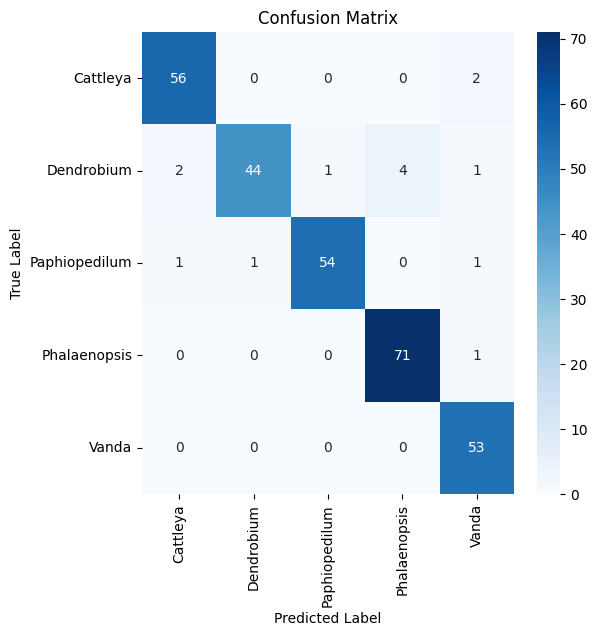

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_generator.classes, predicted_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predicted_classes, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

     Cattleya       0.95      0.97      0.96        58
   Dendrobium       0.98      0.85      0.91        52
Paphiopedilum       0.98      0.95      0.96        57
 Phalaenopsis       0.95      0.99      0.97        72
        Vanda       0.91      1.00      0.95        53

     accuracy                           0.95       292
    macro avg       0.95      0.95      0.95       292
 weighted avg       0.95      0.95      0.95       292



10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


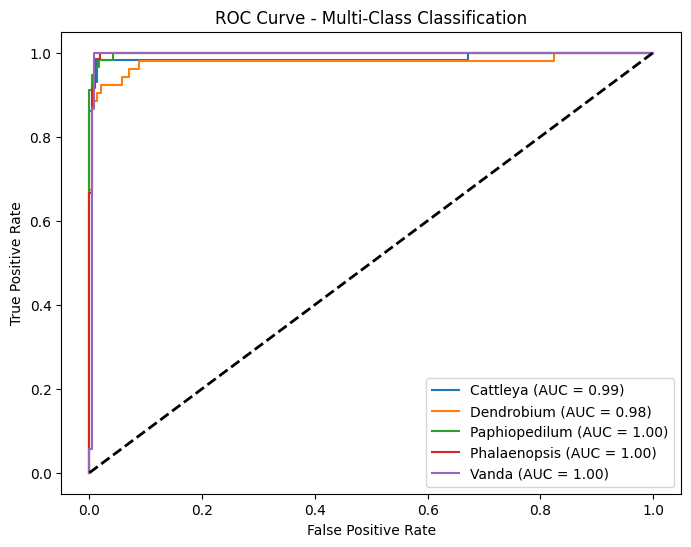

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Ambil jumlah kelas dari test generator
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# One-hot encode label asli (ground truth)
y_test_bin = label_binarize(test_generator.classes, classes=np.arange(n_classes))

# Ambil probabilitas prediksi dari model (bukan kelas prediksi langsung)
y_pred_proba = model.predict(test_generator)

# Plot ROC Curve untuk setiap kelas
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Tambahkan garis diagonal sebagai referensi
plt.plot([0, 1], [0, 1], "k--", lw=2)

# Label dan judul grafik
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()


Total salah klasifikasi: 14


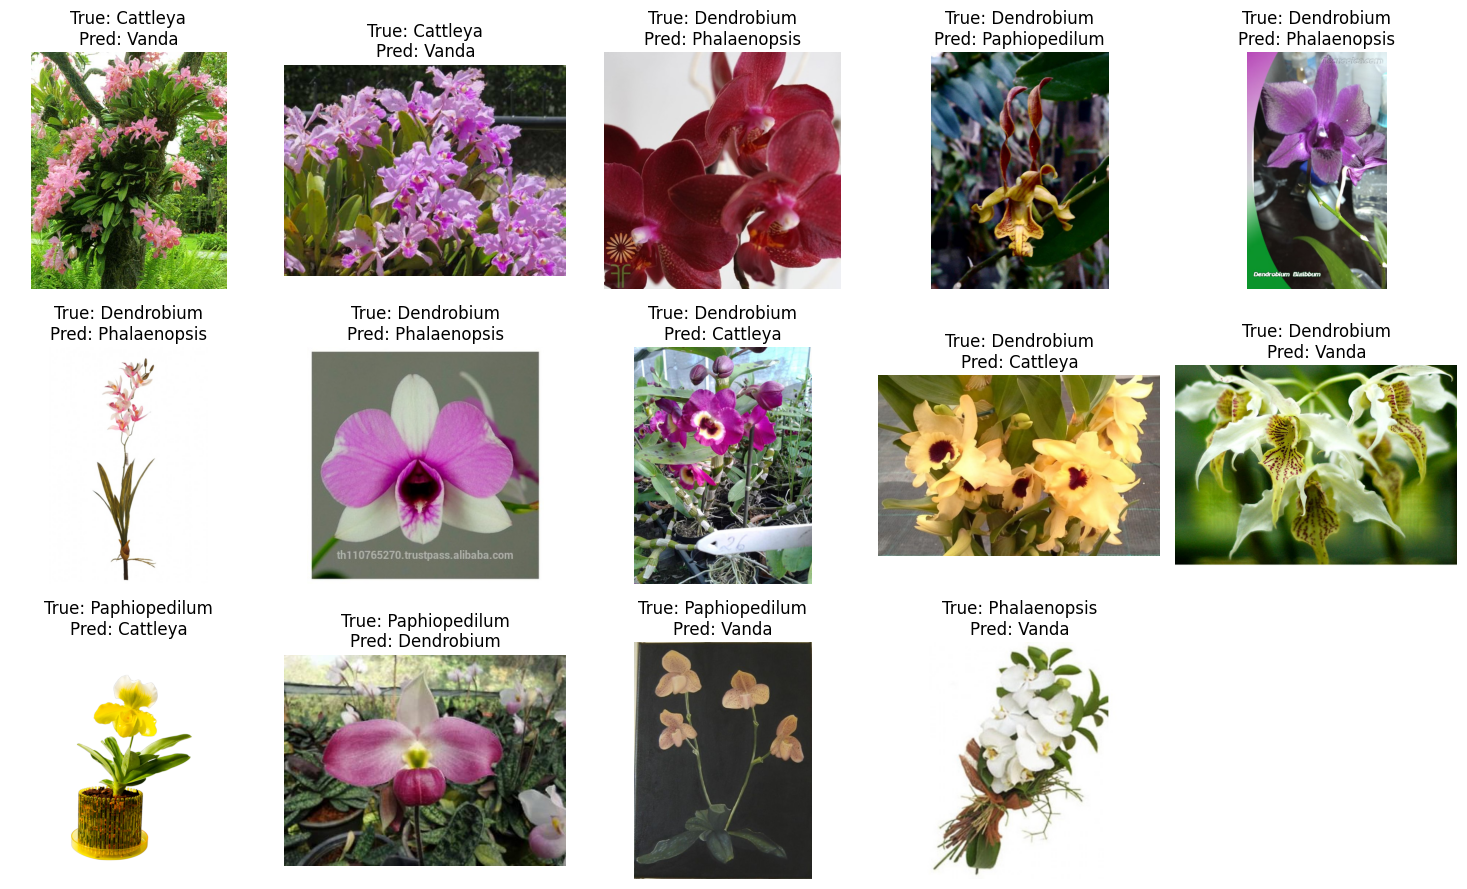

In [ ]:
import math
# Konversi test_generator.classes ke array
y_true = np.array(test_generator.classes)
y_pred = np.array(predicted_classes)

# Cari indeks gambar yang salah klasifikasi
misclassified_idx = np.where(y_true != y_pred)[0]

print(f"Total salah klasifikasi: {len(misclassified_idx)}")

# Menampilkan semua gambar yang salah
num_images = len(misclassified_idx)  # Menampilkan semua gambar
ncols = 5  # Jumlah kolom
nrows = math.ceil(num_images / ncols)  # Hitung jumlah baris

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))  # Sesuaikan ukuran

for i, idx in enumerate(misclassified_idx):
    row, col = divmod(i, ncols)
    img_path = test_generator.filepaths[idx]
    true_label = y_true[idx]
    pred_label = y_pred[idx]

    # Load gambar
    image = plt.imread(img_path)

    ax = axes[row, col] if nrows > 1 else axes[col]  # Jika hanya 1 baris
    ax.imshow(image)
    ax.set_title(f"True: {list(test_generator.class_indices.keys())[true_label]}\nPred: {list(test_generator.class_indices.keys())[pred_label]}")
    ax.axis("off")

# Hapus subplot kosong jika jumlah gambar tidak pas dengan grid
for i in range(num_images, nrows * ncols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()